In [1]:

from tqdm import tqdm
from pathlib import Path
from natsort import natsorted

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

# for evo ######################################################################
from evo.tools import log
log.configure_logging(verbose=False, debug=False, silent=False)

import pprint
import numpy as np

from evo.tools import plot
import matplotlib.pyplot as plt

# temporarily override some package settings
from evo.tools.settings import SETTINGS
SETTINGS.plot_usetex = False

plot.apply_settings(SETTINGS)
%matplotlib inline

from evo.tools import file_interface
from evo.core import metrics
from evo.core.units import Unit
#############################################################################

# reload notebook automatically after changes to source python files
%load_ext autoreload
%autoreload 2

# change base folder to parent
import os
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
print(os.getcwd())

/home/onyx/work_dirs/rjayanti/mast3r-vloc


ref poses: (2939, 7)
Resizing intrinsics by [0.4 0.4]
K:
[[257.62808   0.      258.38455]
 [  0.      257.00912 144.67647]
 [  0.        0.        1.     ]],
W: 1280.0, H: 720.0
query poses: (83, 7)


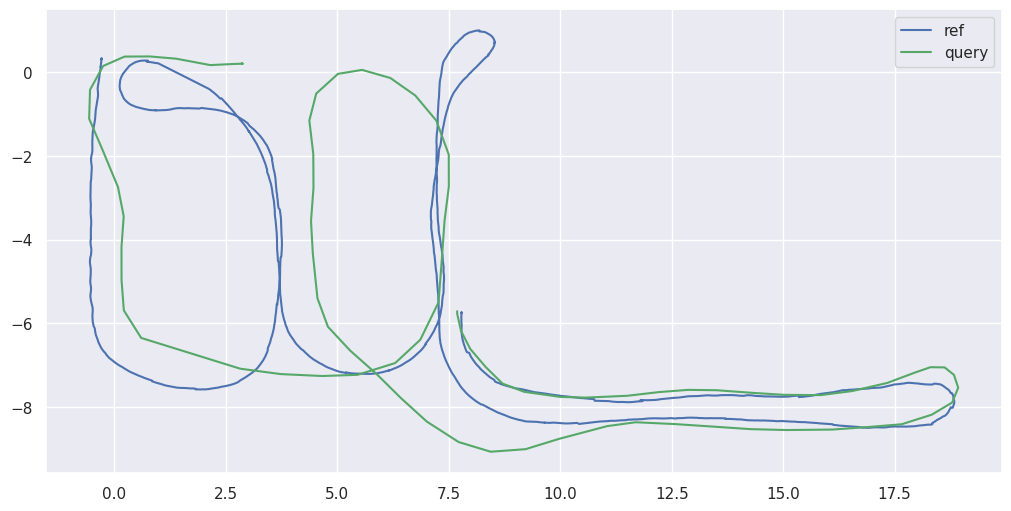

In [2]:
from src.datasets.dataset_utils import read_intrinsics, load_tum_poses, PoseMode

dataset_root = Path("data/rrc-lab-data/wheelchair-runs-20241220/")
ref_scene_folder = dataset_root / "run-1-wheelchair-mapping"
query_scene_folder = dataset_root / "run-2-wheelchair-query"

ref_poses_file = ref_scene_folder / "poses_tum.txt"
_, ref_poses = load_tum_poses(ref_poses_file, PoseMode.TUM)
ref_rgb_folder = ref_scene_folder / "rgb"
ref_rgb_files = natsorted(list(ref_rgb_folder.glob("*.png")))
assert len(ref_rgb_files) == ref_poses.shape[0]
print(f"ref poses: {ref_poses.shape}")

query_poses_file = query_scene_folder / "poses_tum.txt"
_, query_poses = load_tum_poses(query_poses_file, PoseMode.TUM)
query_rgb_folder = query_scene_folder / "rgb"
query_rgb_files = natsorted(list(query_rgb_folder.glob("*.png")))

K_common, W, H = read_intrinsics(ref_scene_folder / "intrinsics.txt", resize=[512, 288])
print(f"K:\n{K_common},\nW: {W}, H: {H}")

# subsample query poses
SUBSAMPLE_FACTOR = 30
query_poses = query_poses[::SUBSAMPLE_FACTOR]
query_rgb_files = query_rgb_files[::SUBSAMPLE_FACTOR]


assert len(query_rgb_files) == query_poses.shape[0]
print(f"query poses: {query_poses.shape}")

# plot trajectory
plt.figure(figsize=(10, 5))
plt.plot(ref_poses[:, 0], ref_poses[:, 1], label="ref")
plt.plot(query_poses[:, 0], query_poses[:, 1], label="query")
plt.legend()
plt.show()

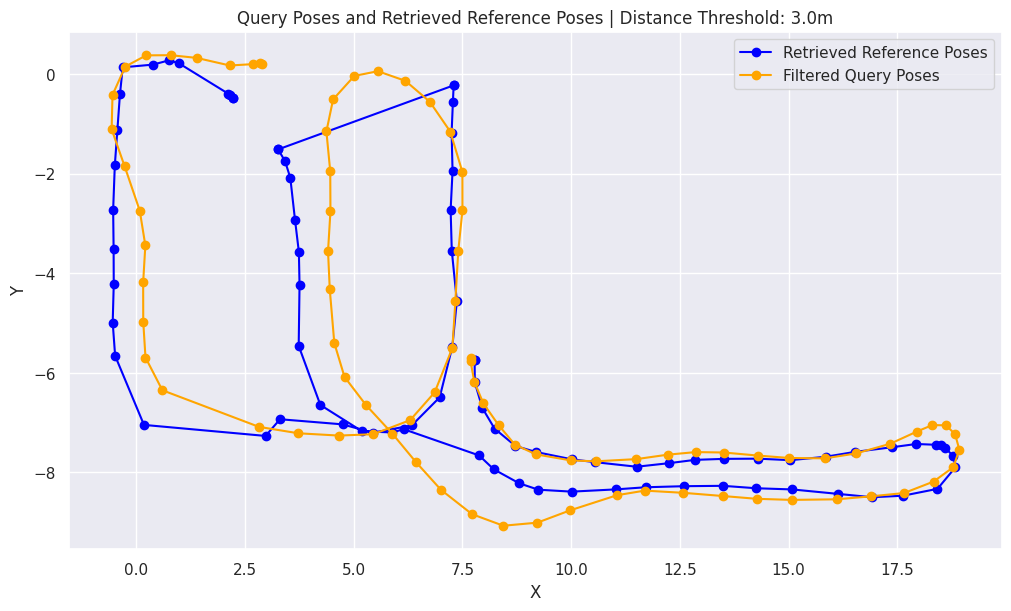

In [3]:
from scipy.spatial import KDTree
ref_kd_tree = KDTree(ref_poses[:, :3])

# Loop over all query images and retrieve the nearest reference pose
DIST_THRESHOLD = 3.0  # Threshold for filtering out poses that are too far

retrieved_ref_poses = []
filtered_query_poses = []
for query_pose in query_poses:
    distance, ref_idx = ref_kd_tree.query(query_pose[:3])  # Using tx, ty, tz for querying
    if distance < DIST_THRESHOLD:  # Skip if the nearest pose is 3m or further
        ref_pose = ref_poses[ref_idx]
        retrieved_ref_poses.append(ref_pose)
        filtered_query_poses.append(query_pose)

# Convert lists to numpy arrays for easier plotting
filtered_query_positions = np.array(filtered_query_poses)[:, :2]  # Assuming the poses are in columns 1 to 3
retrieved_ref_positions = np.array(retrieved_ref_poses)[:, :2]  # Assuming the poses are in columns 1 to 3

# write poses to file in tum format with timestamps as index
def write_tum_poses(file_path, poses):
    with open(file_path, 'w') as f:
        for i, pose in enumerate(poses):
            f.write(f"{i} " + " ".join(map(str, pose)) + "\n")

filtered_query_poses_file = query_scene_folder / "filtered_poses_tum.txt"
retrieved_ref_poses_file = query_scene_folder / "retrieved_ref_poses_tum.txt"

write_tum_poses(filtered_query_poses_file, filtered_query_poses)
write_tum_poses(retrieved_ref_poses_file, retrieved_ref_poses)

# Plot the query poses and retrieved reference poses
plt.figure(figsize=(10, 6))

plt.plot(retrieved_ref_positions[:, 0], retrieved_ref_positions[:, 1], 'bo-', label='Retrieved Reference Poses')
plt.plot(filtered_query_positions[:, 0], filtered_query_positions[:, 1], 'o-', color='orange', label='Filtered Query Poses')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Query Poses and Retrieved Reference Poses | Distance Threshold: {DIST_THRESHOLD}m') 
plt.legend()

plt.show()

In [4]:
from mast3r_src.model import AsymmetricMASt3R

from dust3r_src.dust3r.inference import inference
from dust3r_src.dust3r.utils.image import load_images

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model_name = "./checkpoints/mast3r/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth"
model = AsymmetricMASt3R.from_pretrained(model_name).to(device) # 3.178 GB model

/scratch/public_scratch/toponav/miniconda3/envs/mast3r/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/scratch/public_scratch/toponav/miniconda3/envs/mast3r/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Using device: cuda
... loading model from ./checkpoints/mast3r/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth
instantiating : AsymmetricMASt3R(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100',img_size=(512, 512), head_type='catmlp+dpt', output_mode='pts3d+desc24', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), patch_embed_cls='PatchEmbedDust3R', two_confs=True, desc_conf_mode=('exp', 0, inf), landscape_only=False)
<All keys matched successfully>


In [5]:
import cv2
def backproject_3d(uv, depth, K):
    '''
    Backprojects 2d points given by uv coordinates into 3D using their depth values and intrinsic K
    :param uv: array [N,2]
    :param depth: array [N]
    :param K: array [3,3]
    :return: xyz: array [N,3]
    '''

    uv1 = np.concatenate([uv, np.ones((uv.shape[0], 1))], axis=1)
    xyz = depth.reshape(-1, 1) * (np.linalg.inv(K) @ uv1.T).T
    return xyz

class PnPSolver:
    '''Estimate relative pose (metric) using Perspective-n-Point algorithm (2D-3D) correspondences'''

    def __init__(self):
        # PnP RANSAC parameters
        self.ransac_iterations = 1000
        self.reprojection_inlier_threshold = 3
        self.confidence = 0.9999

    def estimate_pose(self, pts0, pts1, depth_0, K_common):
        # uses nearest neighbour
        pts0 = np.int32(pts0)

        if len(pts0) < 4:
            return np.full((3, 3), np.nan), np.full((3, 1), np.nan), 0

        # get depth at correspondence points
        depth_pts0 = depth_0[pts0[:, 1], pts0[:, 0]]

        # remove invalid pts (depth == 0)
        valid = depth_pts0 > depth_0.min()
        if valid.sum() < 4:
            return np.full((3, 3), np.nan), np.full((3, 1), np.nan), 0
        pts0 = pts0[valid]
        pts1 = pts1[valid].astype(np.float32)
        depth_pts0 = depth_pts0[valid]

        # backproject points to 3D in each sensors' local coordinates
        K0 = K_common
        K1 = K_common
        xyz_0 = backproject_3d(pts0, depth_pts0, K0)

        # get relative pose using PnP + RANSAC
        succ, rvec, tvec, inliers = cv2.solvePnPRansac(
            xyz_0, pts1, K1,
            None, iterationsCount=self.ransac_iterations,
            reprojectionError=self.reprojection_inlier_threshold, confidence=self.confidence,
            flags=cv2.SOLVEPNP_P3P)

        # refine with iterative PnP using inliers only
        if succ and len(inliers) >= 6:
            succ, rvec, tvec, _ = cv2.solvePnPGeneric(xyz_0[inliers], pts1[inliers], K1, None, useExtrinsicGuess=True, rvec=rvec, tvec=tvec, flags=cv2.SOLVEPNP_ITERATIVE)
            rvec = rvec[0]
            tvec = tvec[0]

        # avoid degenerate solutions
        if succ:
            if np.linalg.norm(tvec) > 1000:
                succ = False

        if succ:
            R, _ = cv2.Rodrigues(rvec)
            t = tvec.reshape(3, 1)
        else:
            R = np.full((3, 3), np.nan)
            t = np.full((3, 1), np.nan)
            inliers = []

        return R, t, len(inliers)

In [6]:
from mast3r_src.fast_nn import fast_reciprocal_NNs
from src.utils.tf_utils import compose_qt_tf
device = 'cuda'

FILTERED_COUNT = len(filtered_query_poses)
image_gt_poses_list_kitti = []

for i in range(FILTERED_COUNT):
    image_q_path = query_rgb_files[int(filtered_query_poses[i][0])]
    image_r_path = ref_rgb_files[int(retrieved_ref_poses[i][0])]

    images = load_images([str(image_r_path), str(image_q_path)], size=512)
    output = inference([tuple(images)], model, device, batch_size=1, verbose=False)

    # at this stage, you have the raw dust3r predictions
    view1, pred1 = output['view1'], output['pred1']
    print(f'view1: {view1["true_shape"]}, pred1: {pred1["desc"].shape}, {pred1["pts3d"].shape}')
    view2, pred2 = output['view2'], output['pred2']

    desc1, desc2 = pred1['desc'].squeeze(0).detach(), pred2['desc'].squeeze(0).detach()

    # find 2D-2D matches between the two images
    matches_im0, matches_im1 = fast_reciprocal_NNs(desc1, desc2, subsample_or_initxy1=8,
                                                    device=device, dist='dot', block_size=2**13)

    # ignore small border around the edge
    H0, W0 = view1['true_shape'][0]
    valid_matches_im0 = (matches_im0[:, 0] >= 3) & (matches_im0[:, 0] < int(W0) - 3) & (
        matches_im0[:, 1] >= 3) & (matches_im0[:, 1] < int(H0) - 3)

    H1, W1 = view2['true_shape'][0]
    valid_matches_im1 = (matches_im1[:, 0] >= 3) & (matches_im1[:, 0] < int(W1) - 3) & (
        matches_im1[:, 1] >= 3) & (matches_im1[:, 1] < int(H1) - 3)

    valid_matches = valid_matches_im0 & valid_matches_im1
    matches_im0, matches_im1 = matches_im0[valid_matches], matches_im1[valid_matches]

    depth_im0 = pred1['pts3d'][..., 2].squeeze(0).cpu().numpy()

    # run PnP solver
    solver = PnPSolver()
    R, t, inliers = solver.estimate_pose(matches_im0, matches_im1, depth_im0, K_common)
    
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = t.squeeze()
    
    # reference tranform
    retrieved_ref_pose = retrieved_ref_poses[i]
    qvec_ref = retrieved_ref_pose[3:]
    tvec_ref = retrieved_ref_pose[:3]
    tf_ref= compose_qt_tf(qvec_ref, tvec_ref, fix_qvec=True)
    
    # transform from current reference (relative) to global by multiplying with reference pose
    T_transformed = tf_ref @ T
    
    image_gt_poses_list_kitti.append(T_transformed)

image_gt_poses_kitti = np.array([pose[:3, :].reshape(-1) for pose in image_gt_poses_list_kitti])
gt_poses_file_kitti = Path("./data") / 'pred_image_right_poses_kitti_query_down.txt'
np.savetxt(gt_poses_file_kitti, image_gt_poses_kitti, fmt='%.6f')
print(f'> Saved GT camera poses to {gt_poses_file_kitti}')

>> Loading a list of 2 images
 - adding data/rrc-lab-data/wheelchair-runs-20241220/run-1-wheelchair-mapping/rgb/7.png with resolution 1280x720 --> 512x288
 - adding data/rrc-lab-data/wheelchair-runs-20241220/run-2-wheelchair-query/rgb/210.png with resolution 1280x720 --> 512x288
 (Found 2 images)


/home/onyx/work_dirs/rjayanti/mast3r-vloc/dust3r_src/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/onyx/work_dirs/rjayanti/mast3r-vloc/dust3r_src/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/onyx/work_dirs/rjayanti/mast3r-vloc/dust3r_src/dust3r/inference.py:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


view1: tensor([[288, 512]], dtype=torch.int32), pred1: torch.Size([1, 288, 512, 24]), torch.Size([1, 288, 512, 3])
>> Loading a list of 2 images
 - adding data/rrc-lab-data/wheelchair-runs-20241220/run-1-wheelchair-mapping/rgb/7.png with resolution 1280x720 --> 512x288
 - adding data/rrc-lab-data/wheelchair-runs-20241220/run-2-wheelchair-query/rgb/210.png with resolution 1280x720 --> 512x288
 (Found 2 images)
view1: tensor([[288, 512]], dtype=torch.int32), pred1: torch.Size([1, 288, 512, 24]), torch.Size([1, 288, 512, 3])
>> Loading a list of 2 images
 - adding data/rrc-lab-data/wheelchair-runs-20241220/run-1-wheelchair-mapping/rgb/7.png with resolution 1280x720 --> 512x288
 - adding data/rrc-lab-data/wheelchair-runs-20241220/run-2-wheelchair-query/rgb/210.png with resolution 1280x720 --> 512x288
 (Found 2 images)
view1: tensor([[288, 512]], dtype=torch.int32), pred1: torch.Size([1, 288, 512, 24]), torch.Size([1, 288, 512, 3])
>> Loading a list of 2 images
 - adding data/rrc-lab-data/w

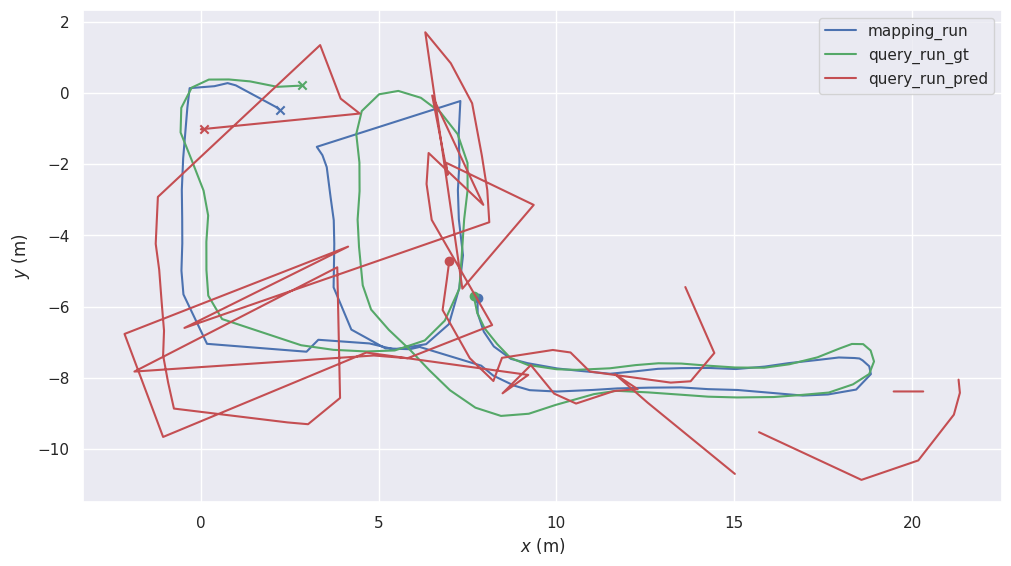

In [7]:
tum_mapping = file_interface.read_tum_trajectory_file(retrieved_ref_poses_file)
tum_query_gt = file_interface.read_tum_trajectory_file(filtered_query_poses_file)
kitti_query_pred = file_interface.read_kitti_poses_file(gt_poses_file_kitti)

fig = plt.figure(figsize=(10, 20))
traj_by_label = {
    "mapping_run": tum_mapping, 
    "query_run_gt": tum_query_gt,
    "query_run_pred": kitti_query_pred,
}

plot.trajectories(fig, traj_by_label, plot.PlotMode.xy, plot_start_end_markers=True)
plt.show()

{'max': nan,
 'mean': nan,
 'median': nan,
 'min': nan,
 'rmse': nan,
 'sse': nan,
 'std': nan}


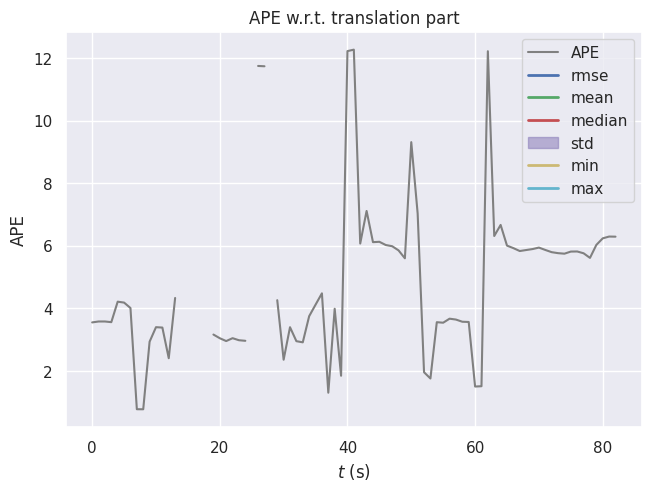

In [8]:
pose_relation = metrics.PoseRelation.translation_part
data = (tum_query_gt, kitti_query_pred)

ape_metric = metrics.APE(pose_relation)
ape_metric.process_data(data)

ape_stats = ape_metric.get_all_statistics()
pprint.pprint(ape_stats)

START_POSE = 0
END_POSE = 83

# create an x array with the time in seconds corresponding to each pose
seconds_from_start = list(range(START_POSE, END_POSE))

fig = plt.figure()
plot.error_array(fig.gca(), ape_metric.error, x_array=seconds_from_start,
                statistics={s:v for s,v in ape_stats.items() if s != "sse"},
                name="APE", title="APE w.r.t. " + ape_metric.pose_relation.value, xlabel="$t$ (s)")
plt.show()

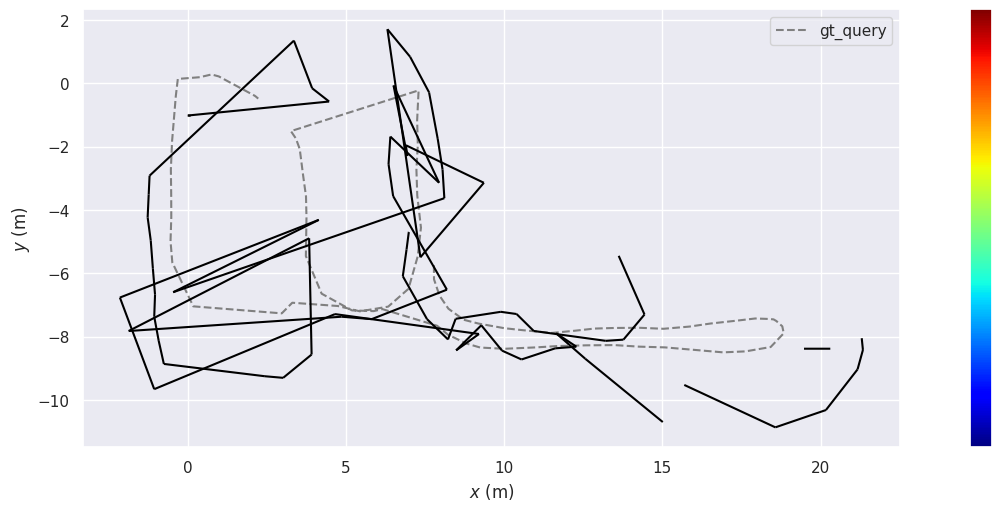

In [9]:
plot_mode = plot.PlotMode.xy
fig = plt.figure(figsize=(15, 5))
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, tum_mapping, '--', "gray", "gt_query")
plot.traj_colormap(ax, kitti_query_pred, ape_metric.error, plot_mode, min_map=ape_stats["min"], max_map=ape_stats["max"])
ax.legend()
plt.show()